# Music

In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [45]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

### Download dataset from here:  
https://s3-us-west-2.amazonaws.com/ashaw-music/v6/v6.tar.gz

In [6]:
path = Path('data/midi/v6/midi_transcribe/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep10_run2_bptt256_mem1024_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep10_run2_bptt256_mem1024.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/2_ep50_run2_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/3_ep1_run2_bptt256_mem1024_bias.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/3_ep1_run2_bptt256_mem1024_bias_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/2_ep50_ru

## Download pretrained model from here:
https://s3-us-west-2.amazonaws.com/ashaw-music/v6/shortdur/models/fastai/txl/hook/4_ep20_run2_bptt256_mem1024_full.pth

In [7]:
model_path = 'fastai/txl/hook/4_ep20_run2_bptt256_mem1024_full'

In [8]:
bs=8
bptt=500

In [9]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 17, ..., 43, 29, 57, 29]))

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

In [11]:
data.train_dl.dl.dataset.idx.shuffle()

In [12]:
data.train_dl.dl.dataset.shuffle

True

In [13]:
data.train_dl.dl.dataset.idx.idx

array([ 2244, 15454,  5292,  5488, ..., 16682,  3550,  5128,  5702])

### Load Learner

In [14]:
cuda_enabled = torch.cuda.is_available()

In [15]:
tfmerXL_lm_config['ctx_len'] = 512
tfmerXL_lm_config['mem_len'] = 1024

In [16]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:223: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [17]:
learn = learn.load(model_path, strict=False)

## Done

In [18]:
# learn.show_results(rows=5, max_len=25)

In [51]:
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)

file = np.random.choice(files); file

PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/r/rebecca-sugar/full-disclosure---steven-universe/chorus_key.txt')

In [52]:
# Loading from specific file
# edm_f = [f for f in files if 'avicii/waiting' in str(f)]; edm_f
# file = edm_f[1]

[PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/chorus_key.txt'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/verse_key.txt'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/intro_key.txt')]

### Create seed sequence

In [56]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(236,
 '|| t10 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4')

In [57]:
ns = str2stream(seed)
ns.show('midi')

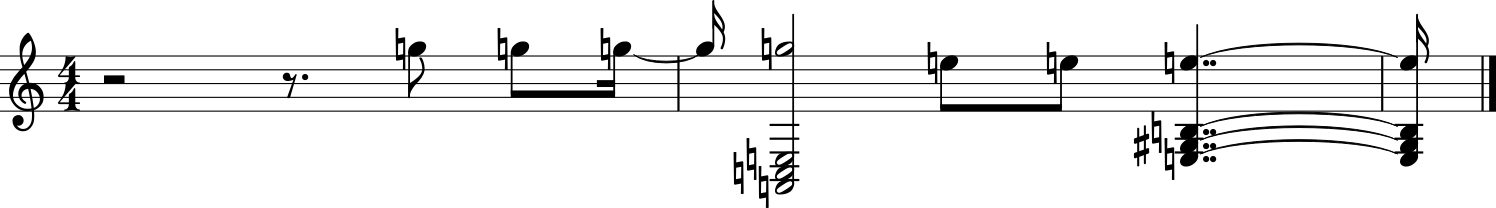

In [58]:
ns = str2stream(seed).show()

### Full song

In [60]:
# full song
str2stream(' '.join(notes)).show('midi')

### Predictions without beam search

In [61]:
pred_out = learn.predict(seed, n_words=200, temperature=1); pred_out

'|| t10 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t3 nE5 t4 || t3 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nA2 t8 nC3 t8 nE3 t8 nG5 t6 || t5 nG5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t3 nE5 t4 || t3 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nG2 t32 nB2 t32 nD3 t32 nD5 t16 || t13 nG4 t2 || t1 nG4 t16 || t15 nG2 t16 nB2 t16 nD3 t16 nD5 t4 || t3 nD5 t2 || t1 nD5 t2'

In [63]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t3 nE5 t4 || t3 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nA2 t8 nC3 t8 nE3 t8 nG5 t6 || t5 nG5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t3 nE5 t4 || t3 nF3 t8 nA3 t8 nC4 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nG3 t8 nB3 t8 nD4 t8 nE5 t4 || t3 nE5 t4 || t3 nG2 t32 nB2 t32 nD3 t32 nD5 t16 || t13 nG4 t2 || t1 nG4 t16 || t15 nG2 t16 nB2 t16 nD3 t16 nD5 t4 || t3 nD5 t2 || t1 nD5 t2'

In [64]:
ns = str2stream(pred_only)
ns.show('midi')

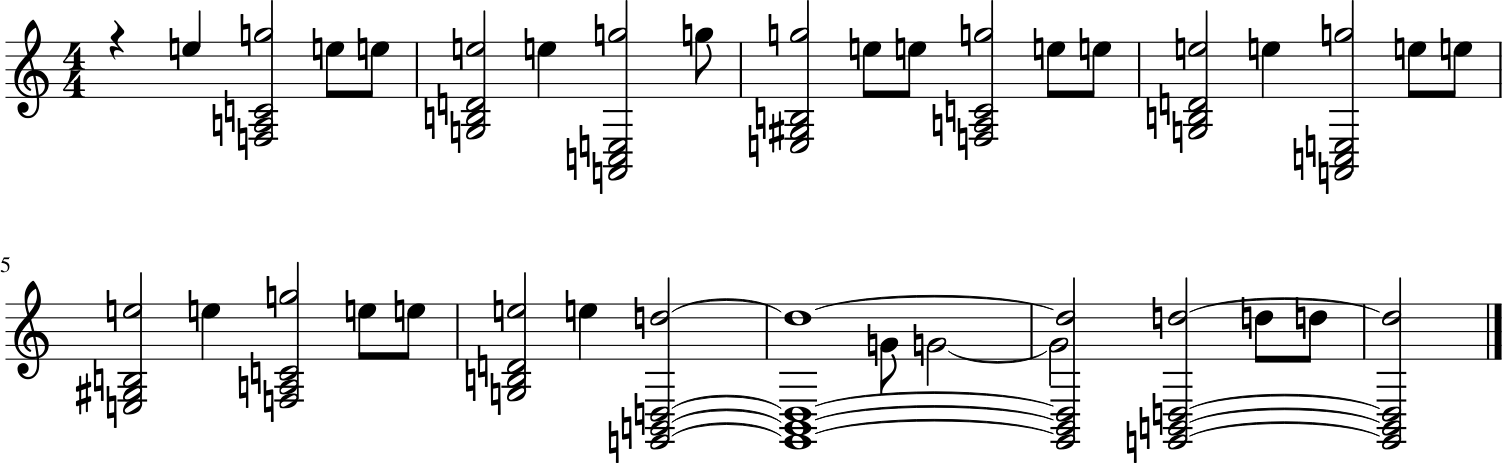

In [65]:
ns.show()

In [66]:
ns = str2stream(pred_out)
ns.show('midi')

In [67]:
str2seq(pred_only)

[[],
 [],
 [],
 [],
 [E5t4],
 [],
 [],
 [],
 [F3t8, A3t8, C4t8, G5t4],
 [],
 [],
 [],
 [E5t2],
 [],
 [E5t2],
 [],
 [G3t8, B3t8, D4t8, E5t4],
 [],
 [],
 [],
 [E5t4],
 [],
 [],
 [],
 [A2t8, C3t8, E3t8, G5t6],
 [],
 [],
 [],
 [],
 [],
 [G5t2],
 [],
 [E3t8, G#3t8, B3t8, G5t4],
 [],
 [],
 [],
 [E5t2],
 [],
 [E5t2],
 [],
 [F3t8, A3t8, C4t8, G5t4],
 [],
 [],
 [],
 [E5t2],
 [],
 [E5t2],
 [],
 [G3t8, B3t8, D4t8, E5t4],
 [],
 [],
 [],
 [E5t4],
 [],
 [],
 [],
 [A2t8, C3t8, E3t8, G5t4],
 [],
 [],
 [],
 [E5t2],
 [],
 [E5t2],
 [],
 [E3t8, G#3t8, B3t8, E5t4],
 [],
 [],
 [],
 [E5t4],
 [],
 [],
 [],
 [F3t8, A3t8, C4t8, G5t4],
 [],
 [],
 [],
 [E5t2],
 [],
 [E5t2],
 [],
 [G3t8, B3t8, D4t8, E5t4],
 [],
 [],
 [],
 [E5t4],
 [],
 [],
 [],
 [G2t32, B2t32, D3t32, D5t16],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [G4t2],
 [],
 [G4t16],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [G2t16, B2t16, D3t16, D5t4],
 [],
 [],
 [],
 [D5t2],
 [],
 [D5t2]]

### Fastai beam search

In [72]:
pred_out = learn.beam_search(seed, n_words=150, top_k=5, temperature=2); pred_out

'|| t10 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 xxbos nG4 t4 nA4'

In [73]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 || t1 nE5 t2 || t1 nE3 t8 nG#3 t8 nB3 t8 nE5 t4 || t9 nG5 t2 || t1 nG5 t2 || t1 nG5 t2 || t1 nA2 t8 nC3 t8 nE3 t8 nG5 t4 || t3 nE5 t2 xxbos nG4 t4 nA4'

In [74]:
ns = str2stream(pred_only)
ns.show('midi')

't'


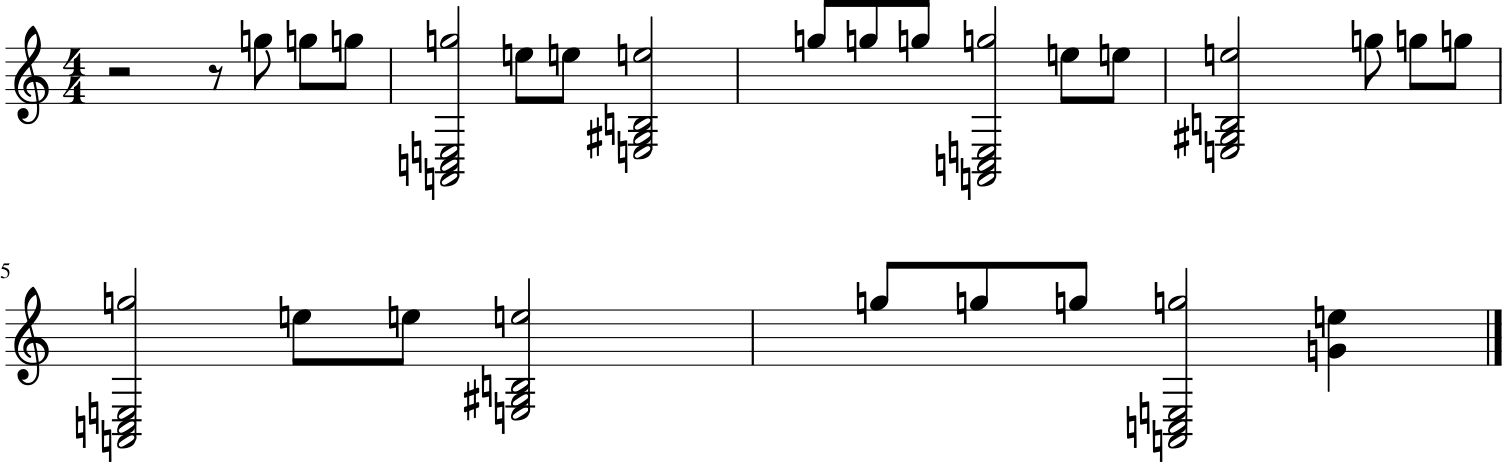

In [75]:
ns.show()

### Beam search

In [29]:
from beam_search import *

In [ ]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

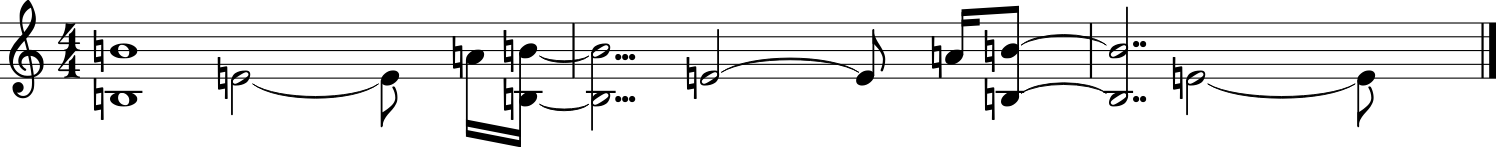

In [75]:
ns_only = str2stream(pred_beam_only).show()

In [76]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

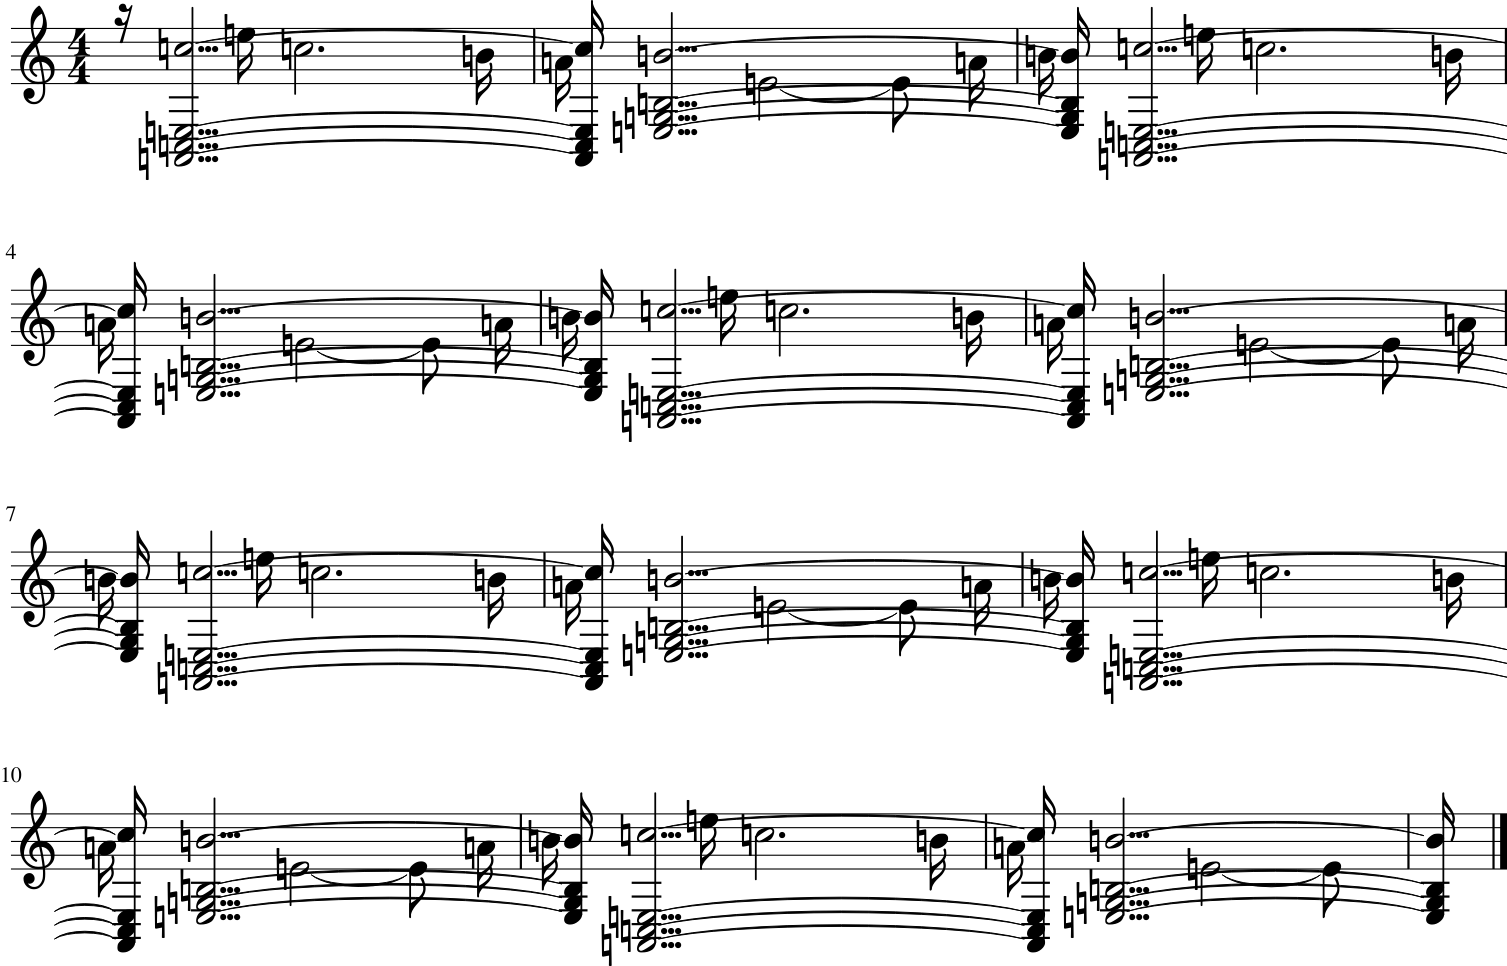

In [77]:
ns = str2stream(pred_beam).show()

In [72]:
ns = str2stream(pred_beam)
ns.show('midi')